In [1]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd
import torchaudio
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from operator import countOf
from tqdm.notebook import tqdm
from torchaudio import datasets as audiodatasets
from IPython.display import Audio


In [2]:
def load_audio(file_path, target_sample_rate):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(sample_rate, target_sample_rate)
        waveform = resampler(waveform)
    
    return waveform.mean(dim=0)

file_path = "./bigSample.mp3"
target_sample_rate = 8000  # TODO: we can mess with this as a future experiment.

waveform = load_audio(file_path, target_sample_rate)
# waveform = waveform[:50000]

if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
    
device = torch.device(dev)
waveform = waveform.to(device)

print(waveform.shape)


torch.Size([95600083])


In [4]:
class AutoRegressive6LayerCNN(nn.Module):
  # never have window_size set smaller than 1024
    def __init__(self, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 128, stride=1)
        self.conv2 = nn.Conv1d(16, 64, 256, stride=1)
        self.conv3 = nn.Conv1d(64, 128, 256, stride=1)
        self.conv4 = nn.Conv1d(128, 64, 256, stride=1)
        self.conv5 = nn.Conv1d(64, 16, 256, stride=1)
        self.conv6 = nn.Conv1d(16, 1, 128, stride=1)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = F.pad(x, (127, 0))
        x = self.conv1(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv2(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv3(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv4(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv5(x)
        x = self.relu(x)
        x = F.pad(x, (127, 0))
        x = self.conv6(x)
        return x

In [5]:
class AutoRegressive4LayerCNN(nn.Module):
  # never have window_size set smaller than 1024
    def __init__(self, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 128, stride=1)
        self.conv2 = nn.Conv1d(16, 64, 256, stride=1)
        self.conv3 = nn.Conv1d(64, 16, 256, stride=1)
        self.conv4 = nn.Conv1d(16, 1, 128, stride=1)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = F.pad(x, (127, 0))
        x = self.conv1(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv2(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv3(x)
        x = self.relu(x)
        x = F.pad(x, (127, 0))
        x = self.conv4(x)
        return x

In [6]:
class AutoRegressive8LayerCNN(nn.Module):
  # never have window_size set smaller than 1024
    def __init__(self, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 128, stride=1)
        self.conv2 = nn.Conv1d(16, 64, 256, stride=1)
        self.conv3 = nn.Conv1d(64, 128, 256, stride=1)
        self.conv4 = nn.Conv1d(128, 256, 256, stride=1)
        self.conv5 = nn.Conv1d(256, 128, 256, stride=1)
        self.conv6 = nn.Conv1d(128, 64, 256, stride=1)
        self.conv7 = nn.Conv1d(64, 16, 256, stride=1)
        self.conv8 = nn.Conv1d(16, 1, 128, stride=1)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = F.pad(x, (127, 0))
        x = self.conv1(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv2(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv3(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv4(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv5(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv6(x)
        x = self.relu(x)
        x = F.pad(x, (255, 0))
        x = self.conv7(x)
        x = self.relu(x)
        x = F.pad(x, (127, 0))
        x = self.conv8(x)        
        return x

In [7]:
class WaveformDataset(Dataset):
    def __init__(self, waveform, target_waveform, window_size):
        self.waveform = waveform
        self.target_waveform = target_waveform
        self.window_size = window_size

    def __len__(self):
        return self.waveform.shape[0] - self.window_size - 1

    def __getitem__(self, idx):
        input_data = self.waveform[idx:idx + self.window_size]
        target_data = self.target_waveform[idx+1:idx + self.window_size+1]
        return input_data, target_data


def split_data(input_waveform, target_waveform, train_ratio, val_ratio):
    total_samples = input_waveform.shape[0] # ERROR by GPT: originally put it as .shape[2] 
    train_idx = int(total_samples * train_ratio)
    val_idx = int(total_samples * (train_ratio + val_ratio))

    train_input, train_target = input_waveform[:train_idx], target_waveform[:train_idx]
    val_input, val_target = input_waveform[train_idx:val_idx], target_waveform[train_idx:val_idx]
    test_input, test_target = input_waveform[val_idx:], target_waveform[val_idx:]

    return train_input, train_target, val_input, val_target, test_input, test_target

train_ratio = 0.7
val_ratio = 0.2

# Define the input and target data

# input_waveform = quantized_waveform[:-1]
# target_waveform = quantized_waveform[1:]

input_waveform = waveform[:-1]
target_waveform = waveform[1:]

train_input, train_target, val_input, val_target, test_input, test_target = split_data(input_waveform, target_waveform, train_ratio, val_ratio)


In [8]:
window_size = 8192
## try huge vals


train_dataset = WaveformDataset(train_input, train_target, window_size)
val_dataset = WaveformDataset(val_input, val_target, window_size)
test_dataset = WaveformDataset(test_input, test_target, window_size)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [9]:
in_channels = 256
num_layers = 3

layers8model = AutoRegressive8LayerCNN(window_size)
layers8model = layers8model.to(device)
layers6model = AutoRegressive6LayerCNN(window_size)
layers6model = layers6model.to(device)
layers4model = AutoRegressive4LayerCNN(window_size)
layers4model = layers4model.to(device)

criterion = nn.MSELoss().to(device)
optimizer8layers = torch.optim.Adam(layers8model.parameters(), lr=0.00001)
optimizer6layers = torch.optim.Adam(layers6model.parameters(), lr=0.00001)
optimizer4layers = torch.optim.Adam(layers4model.parameters(), lr=0.00001)


In [10]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

In [11]:
def plot_val_loss_comparisons(small_model_loss, big_model_loss):
    plt.plot(small_model_loss, label="4 Conv Layer Loss")
    plt.plot(big_model_loss, label="6 Conv Layer Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Validation Loss for Varying Models")


In [12]:
def plot_training_loss_comparisons(small_model_loss, big_model_loss):
    plt.plot(small_model_loss, label="4 Conv Layer Loss")
    plt.plot(big_model_loss, label="6 Conv Layer Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss for Varying Models")


In [13]:
def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=1):
    try:
        train_losses = []
        val_losses = []
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                if count % window_size != 0:
                    count += 1
                    continue
                    
                inputs = inputs.unsqueeze(dim=1)
                labels = labels.unsqueeze(dim=1)
                optimizer.zero_grad()
                
                inputs = inputs.float().to(device) ## updated for GPU
                labels = labels.float().to(device) ## updated for GPU
                outputs = model.forward(inputs)                
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            train_losses.append((total_loss / count))
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    if count % window_size != 0:
                        count += 1
                        continue
                        
                    inputs = inputs.float().to(device) ## updated for GPU
                    labels = labels.float().to(device) ## update for GPU
                    
                    inputs = inputs.unsqueeze(dim=1)
                    labels = labels.unsqueeze(dim=1)
                    outputs = model.forward(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                val_losses.append((total_loss / count))
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return (train_losses, val_losses)


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 1
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 2
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 3
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 4
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 5
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 6
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 7
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 8
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 9
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 10
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 11
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 12
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 13
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 14
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 15
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 16
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 17
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 18
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 19
 Train loss: 

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 1
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 2
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 3
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 4
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 5
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 6
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 7
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 8
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 9
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 10
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 11
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 12
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 13
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 14
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 15
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 16
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 17
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 18
 Train loss: 0.00000
   Val loss: 0.00000

EPOCH 19
 Train loss: 

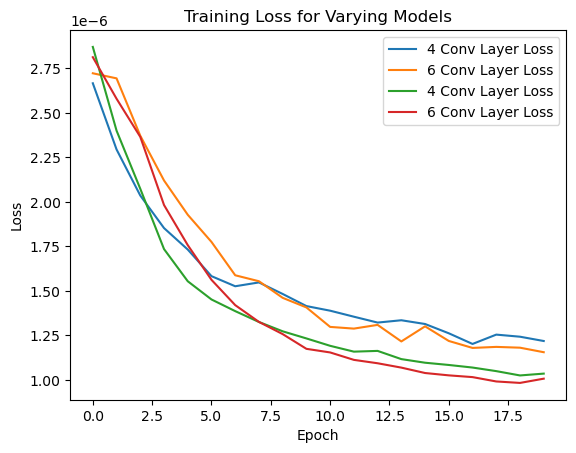

In [14]:
num_epochs = 20
train_4_layer_losses, val_4_layer_losses = train_network(layers4model, train_loader, val_loader, criterion, optimizer4layers, num_epochs)
train_6_layer_losses, val_6_layer_losses = train_network(layers6model, train_loader, val_loader, criterion, optimizer6layers, num_epochs)

plot_val_loss_comparisons(val_4_layer_losses, val_6_layer_losses)
plot_training_loss_comparisons(train_4_layer_losses, train_6_layer_losses)

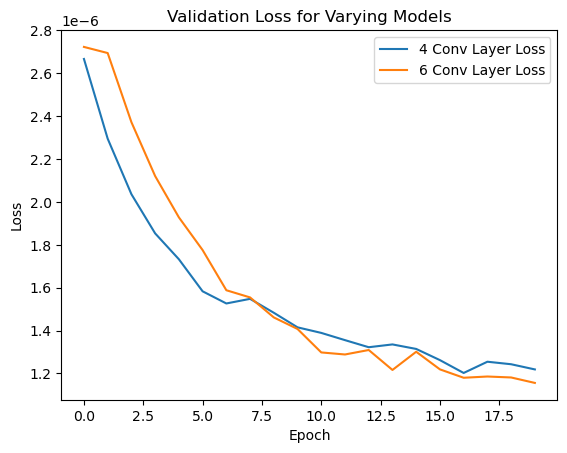

In [15]:
plot_val_loss_comparisons(val_4_layer_losses, val_6_layer_losses)

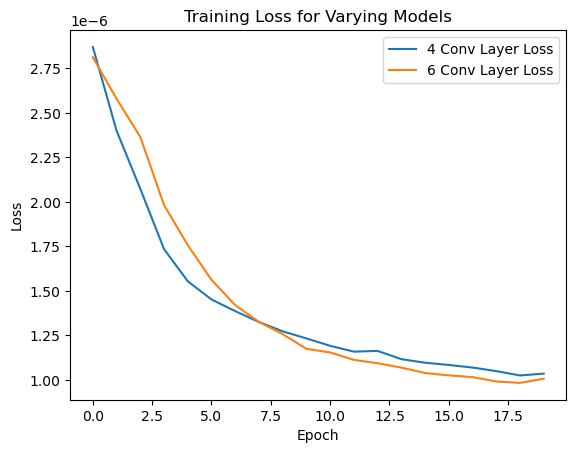

In [16]:
plot_training_loss_comparisons(train_4_layer_losses, train_6_layer_losses)

In [17]:
def generate_sample_output(model, input_samples, sample_length):
    
    model.eval().to(device)
    input_samples = input_samples.to(device)
    input_sequence = input_samples.clone().float()
#     print(input_sequence.shape)
    gen_samples = []
    
    with torch.no_grad():
        
        for i in range(sample_length):
            if i % 10000 == 0:
                print(i)
                
            output = model(input_sequence)
            val = output[0,-1]
            val = torch.tensor([[val]]).to(device)
            
            gen_samples.append(output.squeeze()[-1].item())
            
            input_sequence = input_sequence[:, 1:]
         
            input_sequence = torch.cat((input_sequence, val), dim=1)  

    return gen_samples
    
sample_length = 80000
input_samples, target_data = test_dataset[0]

input_samples = input_samples.unsqueeze(0)

# print(input_samples.shape)
final_4_layer_output = generate_sample_output(layers4model, input_samples, sample_length)
final_6_layer_output = generate_sample_output(layers6model, input_samples, sample_length)
                                      
 

0
10000
20000
30000
40000
50000
60000
70000
0
10000
20000
30000
40000
50000
60000
70000


In [18]:
Audio(np.array(final_4_layer_output), rate = 8000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '4 Layer Waveform')

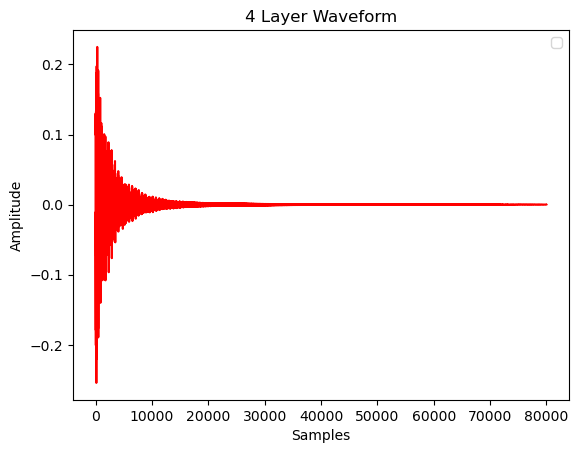

In [19]:
plt.plot(final_4_layer_output, color = 'red')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("4 Layer Waveform")

In [20]:
Audio(np.array(final_6_layer_output), rate = 8000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '6 Layer Waveform')

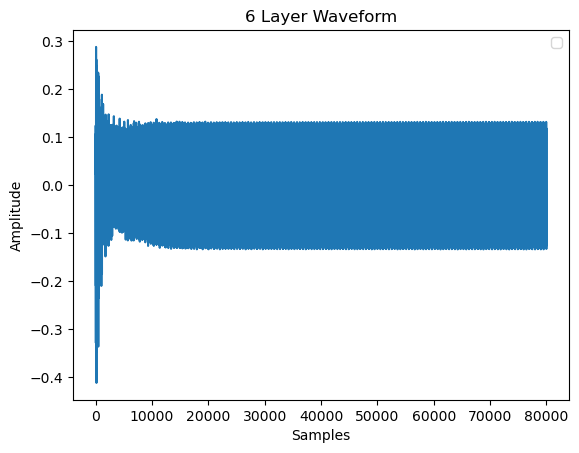

In [21]:
plt.plot(final_6_layer_output)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.title("6 Layer Waveform")

In [ ]:
# big model training kicking off. OK to kill if it takes too long.
train_8_layer_losses, val_8_layer_losses = train_network(layers8model, train_loader, val_loader, criterion, optimizer8layers, num_epochs)

plot_val_loss_comparisons(val_4_layer_losses, val_6_layer_losses, val_8_layer_losses)
plot_training_loss_comparisons(train_4_layer_losses, train_6_layer_losses, train_8_layer_losses)

In [ ]:
final_8_layer_output = generate_sample_output(layers8model, input_samples, sample_length)
Audio(np.array(final_8_layer_output), rate = 8000)
plt.plot(final_8_layer_output)